This notebook explores the graph structure of the bike network of Barcelona:
1. It finds it is not strongly connected and some shortest paths are infinite.
2. Creates new links to connect the disconnected components and create a strongly connected graph.
3. Evaluates the distances of the graph to see if they are correct.

---
Author: Jordi Grau Escolano


# 1. Load data

In [4]:
import sys, random, os, folium
from pathlib import Path
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


project_root = Path().resolve().parents[0]
sys.path.insert(0, str(project_root))
print(project_root)

from paths import *
import src.data_loader as dl
import src.assign_to_nodes.utils.class_node_assigner as cna
import src.optimization.experiments.helper_experiment as he

ROOT = '../'

# 1. Load data
graph_path = f'{ROOT}{RAW_GRAPH}/bike_graph_notebook_raw.graphml'

if not os.path.exists(graph_path):
    print(f'Downloading graph. {graph_path} not found')
    location = 'Barcelona, Barcelona, Catalunya, España'
    G = ox.graph_from_place(location, network_type='bike', simplify=True, retain_all=False)
    ox.save_graphml(G, graph_path)
else:
    G = ox.load_graphml(graph_path)

# 2. Load bcn boundary
bcn_boundary = dl.load_bcn_boundary()

EPSG = 25831
nodes_gdf, _ = ox.graph_to_gdfs(G)
nodes_gdf = nodes_gdf.to_crs(EPSG)
nodes_gdf = nodes_gdf[['geometry', 'x', 'y']]
nodes_gdf.rename(columns={'x': 'lon', 'y': 'lat'}, inplace=True)
nodes_gdf.index.name = 'node_id'
nodes_gdf.index = nodes_gdf.index.astype(int)
nodes_gdf.head()

/home


,geometry,lon,lat
node_id,,,
13019203,POINT (428873.904 4580778.659),2.149443,41.375385
21638831,POINT (431665.633 4579427.183),2.182977,41.363454
21638843,POINT (432058.933 4580190.744),2.187593,41.370365
21638845,POINT (432071.186 4580160.408),2.187743,41.370092
21638855,POINT (432167.223 4580702.446),2.188831,41.374983


# 2. Check strong connextivity

/tmp/ipykernel_23808/1868891661.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 550)


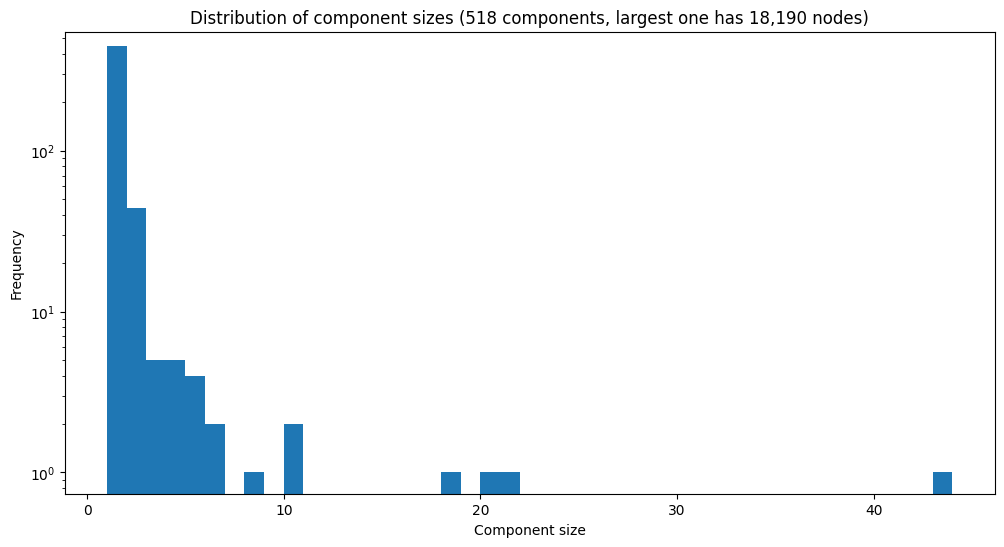

Number of strongly connected components: 518
Sizes of components: [1, 1, 1, 1, 1, 2, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 18, 1, 1, 4, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 3, 1, 4, 1, 1, 1, 1, 1, 21, 2, 20, 2, 1, 1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 18190, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 5, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,

In [3]:
# After fixing the graph, check for strong connectivity (for directed graphs)
def check_strong_connectivity(G):
    is_strongly_connected = nx.is_strongly_connected(G)
    components = list(nx.strongly_connected_components(G))
    component_sizes = sorted([len(c) for c in components])

    if is_strongly_connected:
        print("The graph is strongly connected.")
        return [list(G.nodes())]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.hist(component_sizes[:-1], bins=range(1, max(component_sizes[:-1]) + 2))
        ax.set_title(f'Distribution of component sizes ({str(len(components))} components, largest one has {max(component_sizes):,} nodes)')
        ax.set_xlabel('Component size')
        ax.set_ylabel('Frequency')
        ax.set_yscale('log')
        ax.set_ylim(0, 550)

        plt.show()

        print("Warning: Graph is not strongly connected. Some shortest paths will be infinite.")
        # Optionally, find and report the components
        
        print(f"Number of strongly connected components: {len(components)}")
        print(f"Sizes of components: {[len(c) for c in components]}")
        return components
    

components = check_strong_connectivity(G)

In [ ]:
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)

# Sort components by size and get component sizes for color mapping
sorted_components = sorted(components, key=len, reverse=True)
component_sizes = [len(c) for c in sorted_components]
max_size = max(component_sizes)

# Create random color map based on component sizes
def get_color(size):
    # Use red only for single-node components
    if size == 1:
        return (1.0, 0.0, 0.0, 1.0)  # Red color
    # Use random but consistent colors for each unique size
    random.seed(size)  # Set seed based on size for consistency
    # Avoid red-ish colors for other components
    while True:
        r = random.random()
        g = random.random() 
        b = random.random()
        # Skip if too close to red
        if r < 0.8 or g > 0.2 or b > 0.2:
            return (r, g, b, 1.0)

for i, component in enumerate(sorted_components):
    # Get color based on component size
    component_size = len(component)
    color_rgba = get_color(component_size)
    opacity = 0.2 if i == 0 else 1
    hex_color = mcolors.to_hex(color_rgba)
    
    # Only plot a manageable number of edges per component
    component_edges = list(G.edges(component))
    for u, v in component_edges:
        if component_size == 1:
            # For single-node components, plot the point and its connection
            node = list(component)[0]
            # Plot the node
            folium.CircleMarker(
                location=(G.nodes[node]['y'], G.nodes[node]['x']),
                radius=2,
                color=hex_color,
                fill=True,
                opacity=opacity
            ).add_to(m)
            
            # Find and plot edges connecting to main component
            for pred in G.predecessors(node):
                if pred in sorted_components[0]:
                    points = [(G.nodes[pred]['y'], G.nodes[pred]['x']), 
                             (G.nodes[node]['y'], G.nodes[node]['x'])]
                    folium.PolyLine(points, color=hex_color, weight=2, 
                                  opacity=opacity, arrow_head=30).add_to(m)
                    
            for succ in G.successors(node):
                if succ in sorted_components[0]:
                    points = [(G.nodes[node]['y'], G.nodes[node]['x']),
                             (G.nodes[succ]['y'], G.nodes[succ]['x'])]
                    folium.PolyLine(points, color=hex_color, weight=2,
                                  opacity=opacity, arrow_head=30).add_to(m)
        else:
            # For multi-node components, plot nodes and edges based on component size
            points = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
            if i == 0:
                # For largest component, only plot lines
                folium.PolyLine(points, color=hex_color, weight=2, opacity=opacity).add_to(m)
            else:
                # For other components, plot both lines and nodes
                folium.PolyLine(points, color=hex_color, weight=2, opacity=opacity).add_to(m)
                folium.CircleMarker(
                    location=(G.nodes[u]['y'], G.nodes[u]['x']),
                    radius=2,
                    color=hex_color,
                    fill=True,
                    opacity=opacity
                ).add_to(m)
                folium.CircleMarker(
                    location=(G.nodes[v]['y'], G.nodes[v]['x']),
                    radius=2,
                    color=hex_color,
                    fill=True,
                    opacity=opacity
                ).add_to(m)

m

In [ ]:
def categorize_nodes_by_connectivity(G):
    """
    Categorize nodes based on their connectivity patterns.
    
    Args:
        G (networkx.DiGraph): Input directed graph
        
    Returns:
        dict: Dictionary with lists of nodes in each category:
            - 'no_connections': Nodes with no incoming or outgoing edges
            - 'only_incoming': Nodes with only incoming edges
            - 'only_outgoing': Nodes with only outgoing edges
            - 'both_directions': Nodes with both incoming and outgoing edges
    """
    categories = {
        'no_connections': [],
        'only_incoming': [],
        'only_outgoing': [],
    }

    print(f"There are {len(G.nodes())} nodes in the graph")
    
    for node in G.nodes():
        has_outgoing = False
        has_incoming = False
        
        # Check outgoing edges
        for successor in G.successors(node):
            has_outgoing = True
            break
            
        # Check incoming edges    
        for predecessor in G.predecessors(node):
            has_incoming = True
            break
            
        # Categorize node based on connectivity
        if not has_incoming and not has_outgoing:
            categories['no_connections'].append(node)
        elif has_incoming and not has_outgoing:
            categories['only_incoming'].append(node)
        elif not has_incoming and has_outgoing:
            categories['only_outgoing'].append(node)
            
    return categories

bad_nodes = categorize_nodes_by_connectivity(G)

# print the number of nodes in each category
print("Number of nodes in each category:")
for category, nodes in bad_nodes.items():
    print(f"{category}: {len(nodes)} ({len(nodes)/len(G.nodes())*100:.2f}%)")

There are 18731 nodes in the graph
Number of nodes in each category:
no_connections: 0 (0.00%)
only_incoming: 207 (1.11%)
only_outgoing: 214 (1.14%)


In [ ]:
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)

# Add nodes to the map
for node in G.nodes():
    # Get node coordinates
    lat = nodes_gdf.loc[node]['lat']
    lon = nodes_gdf.loc[node]['lon']
    
    # Determine node color and size
    if node in bad_nodes['only_incoming']:
        color = 'red'
        radius = 3
    elif node in bad_nodes['only_outgoing']:
        color = 'blue'
        radius = 3
    else:
        color = 'gray'
        radius = 1
        
    # Add circle marker
    folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        color=color,
        fill=True,
        fillOpacity=0.7
    ).add_to(m)

# Add edges
for u, v in G.edges():
    # Get coordinates for start and end nodes
    start_lat = nodes_gdf.loc[u]['lat']
    start_lon = nodes_gdf.loc[u]['lon']
    end_lat = nodes_gdf.loc[v]['lat'] 
    end_lon = nodes_gdf.loc[v]['lon']
    
    # Draw line
    folium.PolyLine(
        locations=[[start_lat, start_lon], [end_lat, end_lon]],
        color='gray',
        weight=1,
        opacity=0.7
    ).add_to(m)

# Add legend
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 150px; height: 90px; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white;
            padding: 10px;
            opacity: 0.8;">
            
<p><i class="fa fa-circle" style="color:red"></i> Only Incoming</p>
<p><i class="fa fa-circle" style="color:blue"></i> Only Outgoing</p>
<p><i class="fa fa-circle" style="color:gray"></i> Both Directions</p>

</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

m

# 3. Explore nodes with only one directed link

In [21]:
def find_the_closest_node_of_the_bad_nodes(G, bad_nodes):
    """
    Find the closest node of the bad nodes in the graph.
    """
    dict_incoming_closest_node = {}
    dict_outgoing_closest_node = {}

    for list in ['only_incoming', 'only_outgoing']:
        for node in bad_nodes[list]:
            # drop the node from the graph find the next closest node
            G_prov = G.copy()
            G_prov.remove_node(node)
            # find the closest node
            closest_node = ox.distance.nearest_nodes(G_prov, nodes_gdf.loc[node]['lon'], nodes_gdf.loc[node]['lat'])
            if list == 'only_incoming':
                dict_incoming_closest_node[node] = closest_node
            else:
                dict_outgoing_closest_node[node] = closest_node

    return dict_incoming_closest_node, dict_outgoing_closest_node

dict_incoming_closest_node, dict_outgoing_closest_node = find_the_closest_node_of_the_bad_nodes(G, bad_nodes)

In [22]:
def find_distance_between_closest_nodes(nodes_gdf, dict_incoming_closest_node, dict_outgoing_closest_node):
    """
    Find the distance between the closest nodes of the bad nodes in the graph.
    """
    # create a dataframe with the closest nodes
    df_in = pd.DataFrame.from_dict(dict_incoming_closest_node, orient='index', columns=['closest_node'])
    df_out = pd.DataFrame.from_dict(dict_outgoing_closest_node, orient='index', columns=['closest_node'])

    df_in['only_edge'] = 'incoming'
    df_out['only_edge'] = 'outgoing'

    # merge the dataframes
    df = pd.concat([df_in, df_out])

    # calculate the distance between the closest nodes using the graph and EPSG:25831
    df['distance'] = df.apply(lambda row: ox.distance.euclidean_dist_vec(nodes_gdf.loc[row.name]['geometry'].x, nodes_gdf.loc[row.name]['geometry'].y, nodes_gdf.loc[row['closest_node']]['geometry'].x, nodes_gdf.loc[row['closest_node']]['geometry'].y), axis=1)
    return df

df_closest_nodes_distances = find_distance_between_closest_nodes(nodes_gdf, dict_incoming_closest_node, dict_outgoing_closest_node)

df_closest_nodes_distances

,closest_node,only_edge,distance
30294780,3055187874,incoming,27.874995
30617355,415956314,incoming,11.519827
30685337,1362899989,incoming,11.587577
100474486,1043786418,incoming,4.602694
126763513,2087205012,incoming,20.241495
...,...,...,...
11773845471,11773819921,outgoing,1.840680
12202306548,30242977,outgoing,5.948019
12212522229,12212522231,outgoing,6.580257
12231512456,12231512454,outgoing,23.427526


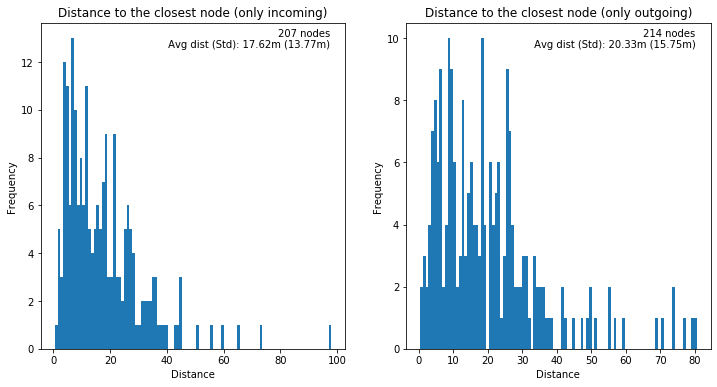

In [23]:
def plot_distance_distributions(df_closest_nodes_distances):
    """
    Plot the distance distributions of the closest nodes.
    """
    df_in = df_closest_nodes_distances[df_closest_nodes_distances['only_edge'] == 'incoming']
    df_out = df_closest_nodes_distances[df_closest_nodes_distances['only_edge'] == 'outgoing']
    
    # plot the distance distributions
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].hist(df_in['distance'], bins=100)
    axs[0].set_title('Distance to the closest node (only incoming)')
    axs[0].set_xlabel('Distance')
    axs[0].set_ylabel('Frequency')
    
    axs[1].hist(df_out['distance'], bins=100)
    axs[1].set_title('Distance to the closest node (only outgoing)')
    axs[1].set_xlabel('Distance')
    axs[1].set_ylabel('Frequency')

    incoming_text = f"{len(df_in)} nodes\n Avg dist (Std): {df_in['distance'].mean():.2f}m ({df_in['distance'].std():.2f}m)"
    outgoing_text = f"{len(df_out)} nodes\n Avg dist (Std): {df_out['distance'].mean():.2f}m ({df_out['distance'].std():.2f}m)"

    axs[0].text(0.95, 0.95, incoming_text, ha='right', va='center', transform=axs[0].transAxes)
    axs[1].text(0.95, 0.95, outgoing_text, ha='right', va='center', transform=axs[1].transAxes)

    plt.show()

plot_distance_distributions(df_closest_nodes_distances)

# 4. Create new edges between the closest nodes

In [24]:
def create_new_edges_between_closest_nodes(G, df_closest_nodes_distances):
    """
    Create new edges between the closest nodes.
    """
    for _, row in df_closest_nodes_distances.iterrows():
        if row['only_edge'] == 'incoming':
            # Node has only incoming edges, so add an outgoing edge
            G.add_edge(row.name, row['closest_node'], 
                      length=row['distance'],
                      edge_type='new')
        else:  # 'outgoing'
            # Node has only outgoing edges, so add an incoming edge
            G.add_edge(row['closest_node'], row.name, 
                      length=row['distance'],
                      edge_type='new')
    return G

G_new = create_new_edges_between_closest_nodes(G, df_closest_nodes_distances)

In [ ]:
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)


# Plot edges with different colors based on edge_type
for u, v, data in G_new.edges(data=True):
    # Get node coordinates
    u_lat = G_new.nodes[u]['y'] 
    u_lon = G_new.nodes[u]['x']
    v_lat = G_new.nodes[v]['y']
    v_lon = G_new.nodes[v]['x']
    
    # Set color and weight based on edge type
    if data.get('edge_type') == 'new':
        color = 'red'
        weight = 8
    else:
        color = 'gray'
        weight = 1
        
    # Draw the edge
    folium.PolyLine(locations=[[u_lat, u_lon], [v_lat, v_lon]], 
                    color=color,
                    weight=weight,
                    opacity=1).add_to(m)

m

# 5. Final graph assessment

In [26]:
bad_nodes = categorize_nodes_by_connectivity(G)

# print the number of nodes in each category
print("Number of nodes in each category:")
for category, nodes in bad_nodes.items():
    print(f"{category}: {len(nodes)} ({len(nodes)/len(G.nodes())*100:.2f}%)")

components = check_strong_connectivity(G)

There are 18731 nodes in the graph
Number of nodes in each category:
no_connections: 0 (0.00%)
only_incoming: 0 (0.00%)
only_outgoing: 0 (0.00%)
Number of strongly connected components: 122
Sizes of components: [2, 2, 5, 2, 4, 4, 2, 1, 2, 1, 2, 1, 18, 1, 1, 4, 2, 1, 2, 2, 2, 21, 2, 20, 2, 2, 3, 2, 3, 2, 3, 1, 2, 2, 1, 2, 2, 4, 3, 5, 4, 11, 2, 3, 2, 2, 2, 2, 18360, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 5, 3, 1, 1, 1, 10, 1, 1, 2, 2, 1, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 3, 2, 3, 3, 2, 2, 1, 2, 4, 2, 2, 2, 1, 2, 3, 2, 1, 1, 1, 2, 1, 3, 1, 6, 2, 4, 11, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 1, 1, 1, 45]


In [27]:
# Print the edges of the component
for component in components:
    if len(component) < 2:
        print(f"Component: {component}")
        for node in component:
            predecessors = list(G.predecessors(node))
            successors = list(G.successors(node))
            print("\tPredec: ", predecessors)
            print("\tSucces: ", successors)

Component: {2533347689}
	Predec:  [1935827759]
	Succes:  [8079247969]
Component: {420058215}
	Predec:  [7159009692]
	Succes:  [9251526562]
Component: {420060603}
	Predec:  [4697774017, 4697774019]
	Succes:  [7159009692]
Component: {420060601}
	Predec:  [420060599]
	Succes:  [4697774026, 4697774023]
Component: {420060599}
	Predec:  [6831747698]
	Succes:  [2111498693, 420060601]
Component: {6831747698}
	Predec:  [420060594]
	Succes:  [420060599, 9251526549]
Component: {1599255986}
	Predec:  [1599256225, 1599256523]
	Succes:  [1599256238]
Component: {1853174602}
	Predec:  [1853174602, 1853174747]
	Succes:  [1853174602]
Component: {30343650}
	Predec:  [21638865]
	Succes:  [30343473, 30343651]
Component: {30297215}
	Predec:  [2965670796]
	Succes:  [1381912176, 30297213]
Component: {4319117005}
	Predec:  [30297225]
	Succes:  [689444888, 4319117010]
Component: {770847823}
	Predec:  [9350842927]
	Succes:  [770847800, 770847806]
Component: {9350842927}
	Predec:  [9350842938]
	Succes:  [77084782

In [ ]:
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)

# Add edges by component with colors - convert NumPy colors to hex strings
colors = plt.cm.rainbow(np.linspace(0, 1, len(components)))
for i, component in enumerate(components):
    # Convert NumPy rgba to hex string for folium
    color_rgba = colors[i]
    hex_color = mcolors.to_hex(color_rgba)
    
    # Only plot a manageable number of edges per component
    component_edges = list(G.edges(component))
    for u, v in component_edges:  # Limit number of edges plotted
        points = [(G.nodes[u]['y'], G.nodes[u]['x']), (G.nodes[v]['y'], G.nodes[v]['x'])]
        folium.PolyLine(points, color=hex_color, weight=2, opacity=0.7).add_to(m)

m

In [29]:
def unify_graph(G):
    """
    To unify the graph, first the edges that unite the components are found. Then,
    a edge on the opposite direction is added.
    
    Parameters:
    -----------
    G : networkx.DiGraph
        The directed graph to unify
        
    Returns:
    --------
    networkx.DiGraph
        A unified graph where all components are strongly connected
    """     
    # Make a copy of the input graph to avoid modifying the original
    unified_G = G.copy()
    
    # Find strongly connected components
    components = list(nx.strongly_connected_components(G))
    print(f"The graph has {len(components)} components.")
    
    if len(components) <= 1:
        # Graph is already strongly connected
        return unified_G
    
    # Create a mapping of nodes to their component
    node_to_component = {}
    for i, component in enumerate(components):
        for node in component:
            node_to_component[node] = i
    
    # Find edges that connect different components and add reverse edges
    edges_added = 0
    for u, v, key in G.edges(keys=True):
        comp_u = node_to_component[u]
        comp_v = node_to_component[v]
        
        # If this edge connects different components
        if comp_u != comp_v:
            # Add the reverse edge if it doesn't exist
            if not unified_G.has_edge(v, u):
                # Get the weight from the forward edge
                data = G.get_edge_data(u, v, key=key)
                
                # Get weight from the first attribute we find (weight, length, or distance)
                if 'weight' in data:
                    weight = float(data['weight'])
                elif 'length' in data:
                    weight = float(data['length'])
                elif 'distance' in data:
                    weight = float(data['distance'])
                else:
                    print(f"No weight found for edge {u} -> {v}")
                    weight = 1000.0  # Default weight
                
                # Add the reverse edge with just the weight attribute
                unified_G.add_edge(v, u, weight=weight)
                edges_added += 1
    
    print(f"Added {edges_added} reverse edges to connect components")
    
    # Verify the graph is now strongly connected
    final_components = list(nx.strongly_connected_components(unified_G))
    
    if len(final_components) > 1:
        print(f"After adding reverse edges, the graph still has {len(final_components)} components.")

    # Final verification
    print(f"Final graph has {len(final_components)} strongly connected component(s)")

    # Convert all 'length' distance attributes to 'weight'
    for u, v, key in unified_G.edges(keys=True):
        data = unified_G.get_edge_data(u, v, key=key)
        if data.get('length') is not None:
            data['weight'] = data['length']
    
    return unified_G



G_unified = unify_graph(G)

The graph has 122 components.
Added 172 reverse edges to connect components
Final graph has 1 strongly connected component(s)


In [ ]:
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)

# Add edges by component with colors - convert NumPy colors to hex strings
components = check_strong_connectivity(G_unified)
colors = plt.cm.rainbow(np.linspace(0, 1, len(components)))
for i, component in enumerate(components):
    # Convert NumPy rgba to hex string for folium
    color_rgba = colors[i]
    hex_color = mcolors.to_hex(color_rgba)
    
    # Only plot a manageable number of edges per component
    component_edges = list(G_unified.edges(component))
    for u, v in component_edges:  # Limit number of edges plotted
        points = [(G_unified.nodes[u]['y'], G_unified.nodes[u]['x']), (G_unified.nodes[v]['y'], G_unified.nodes[v]['x'])]
        folium.PolyLine(points, color=hex_color, weight=2, opacity=0.7).add_to(m)

m

In [ ]:
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)

# Define colors for different edge types
direction_colors = {
    'outgoing': '#0000FF',  # Blue for outgoing edges (one-way)
    'incoming': '#FF0000',  # Red for incoming edges (one-way)
    'bidirectional': '#00FF00'  # Green for bidirectional edges
}

# Create a set of bidirectional edges
bidirectional_edges = set()
for u, v in G_unified.edges():
    if G_unified.has_edge(v, u):
        # This is a bidirectional connection (both directions exist)
        # Store canonically (smaller node id first) to avoid duplicates
        edge_pair = tuple(sorted([u, v]))
        bidirectional_edges.add(edge_pair)

# Process all edges in the graph
plotted_edges = set()  # Keep track of edges we've already plotted

# First, add all bidirectional edges
for u, v in G_unified.edges():
    edge_pair = tuple(sorted([u, v]))
    
    # If this is bidirectional and we haven't plotted it yet
    if edge_pair in bidirectional_edges and edge_pair not in plotted_edges:
        points = [(G_unified.nodes[u]['y'], G_unified.nodes[u]['x']), 
                  (G_unified.nodes[v]['y'], G_unified.nodes[v]['x'])]
        
        folium.PolyLine(
            points, 
            color=direction_colors['bidirectional'], 
            weight=2.5, 
            opacity=0.8,
            tooltip=f"Bidirectional: {u} from/to {v}"
        ).add_to(m)
        
        # Mark both directions as plotted
        plotted_edges.add(edge_pair)

# Then add all one-way edges
for u, v in G_unified.edges():
    edge_pair = tuple(sorted([u, v]))
    
    # If this is not a bidirectional edge (or it's the reverse direction of one we've already plotted)
    if edge_pair not in bidirectional_edges:
        points = [(G_unified.nodes[u]['y'], G_unified.nodes[u]['x']), 
                  (G_unified.nodes[v]['y'], G_unified.nodes[v]['x'])]
        
        folium.PolyLine(
            points, 
            color=direction_colors['outgoing'],  # All one-way edges are "outgoing" from their source
            weight=2, 
            opacity=0.7,
            tooltip=f"One-way: {u} to {v}"
        ).add_to(m)

# Add a legend
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 180px; height: 100px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: white; padding: 10px;
     ">
     <p><b>Edge Direction</b></p>
     <p><i style="background:#0000FF; width:15px; height:15px; display:inline-block;"></i> One-way</p>
     <p><i style="background:#00FF00; width:15px; height:15px; display:inline-block;"></i> Bidirectional</p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

In [ ]:
unified_graph_path = f'/home/ubuntu/BigData/BSS_station_optimization/data/raw/graph/bike_graph_notebook_processed_2025-03-19.graphml'
ox.save_graphml(G_unified, unified_graph_path)

# 6. Checking if the distances between nodes are correct

In [ ]:
import src.optimization.helper_optimization as ho

distance_matrix, id_to_idx, idx_to_id = ho.compute_all_pairs_shortest_paths_dijkstra(G, weight='weight')

In [ ]:
import random

# Find three pairs of nodes that are less than 1000 meters apart
node_pairs = []
counter = 0
target_distance = 300
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix[i])):
        if counter >= 2:
            break
        if i == j:
            continue
        if (distance_matrix[i][j] < target_distance) & (distance_matrix[j][i] < target_distance):
            print(f"Distance between nodes {idx_to_id[i]} and {idx_to_id[j]} (both directions): {distance_matrix[i][j]:.1f} and {distance_matrix[j][i]:.1f} meters")
            counter += 1
            node_pairs.append((i,j))


node_pairs = [(7160883598, 4749816261)]

m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)  # Barcelona coordinates

# Add boundary
folium.GeoJson(bcn_boundary).add_to(m)

# Plot nodes and paths for each pair
for node1_idx, node2_idx in node_pairs:
    try:
        node1_id = idx_to_id[node1_idx]
        node2_id = idx_to_id[node2_idx]
    except:
        node1_id = node1_idx
        node2_id = node2_idx
        node1_idx = id_to_idx[node1_id]
        node2_idx = id_to_idx[node2_id]
    
    # Get coordinates
    node1_lat = nodes_gdf.loc[node1_id]['lat']
    node1_lon = nodes_gdf.loc[node1_id]['lon']
    node2_lat = nodes_gdf.loc[node2_id]['lat']
    node2_lon = nodes_gdf.loc[node2_id]['lon']
    
    # Plot the nodes
    folium.CircleMarker(
        location=[node1_lat, node1_lon],
        radius=5,
        alpha=0.5,
        color='red',
        fill=True,
        popup=f'Node {node1_id}'
    ).add_to(m)
    
    folium.CircleMarker(
        location=[node2_lat, node2_lon],
        radius=5,
        alpha=0.5,
        color='red',
        fill=True,
        popup=f'Node {node2_id}'
    ).add_to(m)
    
    # Calculate midpoint for label
    mid_lat = (node1_lat + node2_lat) / 2
    mid_lon = (node1_lon + node2_lon) / 2
    
    # Get distances in both directions
    dist1to2 = distance_matrix[node1_idx][node2_idx]
    dist2to1 = distance_matrix[node2_idx][node1_idx]
    
    # Get shortest paths in both directions
    path1to2 = nx.shortest_path(G, node1_id, node2_id, weight='weight')
    path2to1 = nx.shortest_path(G, node2_id, node1_id, weight='weight')
    
    # Draw path from node1 to node2
    path_coords1 = []
    for node in path1to2:
        lat = nodes_gdf.loc[node]['lat']
        lon = nodes_gdf.loc[node]['lon']
        path_coords1.append([lat, lon])
    
    folium.PolyLine(
        locations=path_coords1,
        color='olive',
        weight=1,
        alpha=0.5,
        popup=f'{dist1to2:.1f}m →'
    ).add_to(m)
    
    # Draw path from node2 to node1
    path_coords2 = []
    for node in path2to1:
        lat = nodes_gdf.loc[node]['lat']
        lon = nodes_gdf.loc[node]['lon']
        path_coords2.append([lat, lon])
    
    folium.PolyLine(
        locations=path_coords2,
        color='blue',
        weight=1,
        alpha=1,
        popup=f'{dist2to1:.1f}m ←'
    ).add_to(m)
    
    # Add distance labels with larger font and background
    html = f"""
        <div style="
            background-color: white;
            padding: 5px;
            border: 1px solid black;
            font-size: 14px;
            ">
            {dist1to2:.1f}m →<br>
            {dist2to1:.1f}m ←
        </div>
    """
    folium.Popup(
        html,
        permanent=True
    ).add_to(folium.Marker([mid_lat, mid_lon], icon=folium.DivIcon()))

m


Distance between nodes 21638831 and 30317502 (both directions): 225.1 and 225.1 meters
Distance between nodes 21638831 and 1259351650 (both directions): 222.9 and 263.9 meters


In [ ]:
# Plot the best solution in folium
import folium
from itertools import combinations
import networkx as nx
import random

solution = best_nodes_ga[7:9]

# Create a base map centered on Barcelona
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# Add boundary
bcn_boundary = dl.load_bcn_boundary()
folium.GeoJson(bcn_boundary).add_to(m)

df_weighted_osm = df_weighted.to_crs(epsg=4326)

# Plot all selected stations
for node_id in solution:
    node = df_weighted_osm.loc[node_id]
    folium.CircleMarker(
        location=[node.geometry.y, node.geometry.x],
        radius=5,
        color='red',
        fill=True,
        popup=f'Node {node_id}\nScore: {node.norm_score:.3f}'
    ).add_to(m)

# Compute all shortest paths between pairs of nodes at once
all_paths = {}
all_distances = {}
for node1_id in solution:
    for node2_id in solution:
        if node1_id != node2_id:
            try:
                node1_idx = id_to_idx[node1_id]
                node2_idx = id_to_idx[node2_id]
            except:
                node1_idx = node1_id
                node2_idx = node2_id
                node1_id = idx_to_id[node1_idx] 
                node2_id = idx_to_id[node2_idx]
            
            path = nx.shortest_path(G, node1_id, node2_id, weight='weight')
            all_paths[(node1_id, node2_id)] = path
            all_distances[(node1_id, node2_id)] = distance_matrix[node1_idx][node2_idx]

# Generate random colors for each pair of nodes
colors = {}
for node1_id, node2_id in combinations(solution, 2):
    # Generate random hex color
    color = '#%06x' % random.randint(0, 0xFFFFFF)
    colors[(node1_id, node2_id)] = color
    colors[(node2_id, node1_id)] = color

# Draw paths and labels for each pair
for node1_id, node2_id in combinations(solution, 2):
    # Get coordinates
    node1 = df_weighted_osm.loc[node1_id]['geometry']
    node2 = df_weighted_osm.loc[node2_id]['geometry']
    node1_lon = node1.y
    node1_lat = node1.x
    node2_lon = node2.y 
    node2_lat = node2.x
    
    # Calculate midpoint for label
    mid_lat = (node1_lat + node2_lat) / 2
    mid_lon = (node1_lon + node2_lon) / 2
    
    # Get pre-computed distances and paths
    dist1to2 = all_distances[(node1_id, node2_id)]
    dist2to1 = all_distances[(node2_id, node1_id)]
    path1to2 = all_paths[(node1_id, node2_id)]
    path2to1 = all_paths[(node2_id, node1_id)]
    
    # Get color for this pair
    path_color = colors[(node1_id, node2_id)]
    
    # Draw path from node1 to node2 (solid line)
    path_coords1 = []
    for node in path1to2:
        node_geom = df_weighted_osm.loc[node]['geometry']
        path_coords1.append([node_geom.y, node_geom.x])
    
    folium.PolyLine(
        locations=path_coords1,
        color=path_color,
        weight=2,
        alpha=0.8,
        popup=f'{dist1to2:.1f}m'
    ).add_to(m)
    
    # Draw path from node2 to node1 (dashed line)
    path_coords2 = []
    for node in path2to1:
        node_geom = df_weighted_osm.loc[node]['geometry']
        path_coords2.append([node_geom.y, node_geom.x])
    
    folium.PolyLine(
        locations=path_coords2,
        color=path_color,
        weight=2,
        alpha=0.8,
        popup=f'{dist2to1:.1f}m',
        dash_array='8'
    ).add_to(m)


# Display the map
m